In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

#Quickstart

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# root="data"	=> The directory where the dataset will be stored. If "data" doesn’t exist, it will be created.
# train=True =>	This tells PyTorch to load the training set (60,000 images).
# download=True =>	If the dataset is not already present, download it from the internet.
# transform=ToTensor() =>	Apply a transformation that converts each image (PIL format) into a PyTorch tensor and normalizes pixel values to [0.0, 1.0].

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.4MB/s]


In [4]:
batch_size = 64
# This sets the number of samples per batch.

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
# This wraps the training_data (which is a FashionMNIST dataset) in a DataLoader.
# What DataLoader does:
  # Batches the data into size batch_size
  # Allows iterating over the dataset using a for loop
  # Optionally shuffles or loads data in parallel (more on this later)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# output [64, 1, 28, 28]: Each batch contains 64 grayscale images (1 channel, 28x28 pixels) and their 64 labels.

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [5]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
# Checks if any hardware accelerator (GPU or Apple Silicon, etc.) is available.
# If yes, it uses it (e.g., "cuda" for NVIDIA GPU, "mps" for Apple GPU).
# If not, it defaults to "cpu".

# Define model
class NeuralNetwork(nn.Module):
  # define a class that inherits from nn.Module, which is the base class for all PyTorch models.
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        # nn.Flatten() converts the 2D image (28×28) into a 1D vector (784 values).
        # Shape change: [batch_size, 1, 28, 28] ⟶ [batch_size, 784]
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), # input layer
            nn.ReLU(),             # activation function
            nn.Linear(512, 512),   # hidden layer
            nn.ReLU(),             # activation function
            nn.Linear(512, 10)     # output layer
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [6]:
loss_fn = nn.CrossEntropyLoss()
# A loss function measures how far the model’s predictions are from the correct labels (truth). It guides the training process.
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# An optimizer updates the model’s weights based on the computed gradients during backpropagation.

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # This gives you the total number of samples in the dataset (not just in one batch).

    model.train()
    # This sets the model in training mode.
      # It activates dropout, batch norm, etc. if used.
      # Not needed in inference mode (model.eval() is used for testing/validation).

    for batch, (X, y) in enumerate(dataloader):
        # batch: Index of the batch (0, 1, 2, ...)
        # (X, y): A batch of inputs (X) and targets (y) from the dataloader

        # Example shapes:
        #   X: [64, 1, 28, 28]
        #   y: [64]

        X, y = X.to(device), y.to(device)
        # This ensures the data is on the same device as the model (CPU or GPU).
        # Without this, it may causes an error during training

        # Compute prediction error
        pred = model(X)
        # Feeds the batch of inputs X through the model.
        # Returns logits (raw output scores) of shape [batch_size, 10].

        loss = loss_fn(pred, y)
        # Compares predictions (pred) with actual labels (y)
        # Returns the average loss for this batch (a single number).

        # Backpropagation
        loss.backward()
        # Calculates the gradient of the loss w.r.t. each model parameter (using the chain rule).
        # These gradients are stored in parameter.grad.

        optimizer.step()
        # Uses the gradients calculated in loss.backward() to update the model's parameters.

        optimizer.zero_grad()
        # Clears the previous gradients, which accumulate by default in PyTorch.
        # Must do this before the next batch.

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # size: Total number of samples in the test dataset (e.g., 10,000 for FashionMNIST)
    # num_batches: Total number of batches in the test set (e.g., 10,000 / 64 = 157)

    model.eval()
    # This puts the model in evaluation mode:
    #   Disables features like dropout or batch norm updating.
    #   Ensures consistent and correct behavior during testing.

    test_loss, correct = 0, 0
    with torch.no_grad():
      # This tells PyTorch not to compute gradients, which:
      #   Saves memory
      #   Speeds up computations
      # Gradients are only needed for training, not testing.

        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # Moves data to the correct device (CPU/GPU)
            # Performs a forward pass with model(X) to get predictions

            test_loss += loss_fn(pred, y).item()
            # Computes the loss for this batch

            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            # pred.argmax(1)	Finds the index (class) with the highest score for each image
            # == y	Compares predicted labels to true labels
            # .type(torch.float)	Converts the Boolean results (True/False) to floats (1.0 or 0.0)
            # .sum().item()	Sums how many were correct in this batch and converts it to float

    test_loss /= num_batches
    correct /= size
    # test_loss: Average loss across all test batches
    # correct: Fraction of correct predictions (i.e., accuracy) Accuracy = Number of correct predictions / Total number of predictions

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.312341  [   64/60000]
loss: 2.298501  [ 6464/60000]
loss: 2.277543  [12864/60000]
loss: 2.267805  [19264/60000]
loss: 2.243675  [25664/60000]
loss: 2.225574  [32064/60000]
loss: 2.218122  [38464/60000]
loss: 2.192314  [44864/60000]
loss: 2.200360  [51264/60000]
loss: 2.147817  [57664/60000]
Test Error: 
 Accuracy: 47.4%, Avg loss: 2.147647 

Epoch 2
-------------------------------
loss: 2.168075  [   64/60000]
loss: 2.156399  [ 6464/60000]
loss: 2.092921  [12864/60000]
loss: 2.105268  [19264/60000]
loss: 2.045977  [25664/60000]
loss: 1.999271  [32064/60000]
loss: 2.018935  [38464/60000]
loss: 1.944988  [44864/60000]
loss: 1.961071  [51264/60000]
loss: 1.870013  [57664/60000]
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.870504 

Epoch 3
-------------------------------
loss: 1.917784  [   64/60000]
loss: 1.877927  [ 6464/60000]
loss: 1.755903  [12864/60000]
loss: 1.795235  [19264/60000]
loss: 1.683306  [25664/60000]
loss: 1.648238  [32064/600

In [10]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
# test_data[0]: Gets the first image and its label from the dataset.
# [0]: The image (x) – a 1 × 28 × 28 tensor.
# [1]: The label (y) – an integer like 9.

# x: The image
# y: The actual label (e.g., 9 = "Ankle boot")

with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


#Tensors

Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.

Tensors can be initialized in various ways. Take a look at the following examples:

In [11]:
import numpy as np
# Directly from data
# Tensors can be created directly from data. The data type is automatically inferred.

data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

print(x_data)
print(x_data.shape)
print(x_data.ndim)
print(x_data.dtype)
print(x_data.itemsize)
print(x_data.device)
# shape: Returns a tuple representing the shape (dimensions) of the array.
# ndim: Returns the number of dimensions (axes) of the array.
# dtype: Provides the data type of the array elements.
# itemsize: Returns the size in bytes of each element
# device: Device tensor is stored on.

# By default, tensors are created on the CPU. We need to explicitly move tensors to the accelerator using .to method (after checking for accelerator availability). Keep in mind that copying large tensors across devices can be expensive in terms of time and memory!
# We move our tensor to the current accelerator if available
# if torch.accelerator.is_available():
#     tensor = tensor.to(torch.accelerator.current_accelerator())
print("------------------------------------------")
# From a NumPy array
# Tensors can be created from NumPy arrays.

np_array = np.array(data)
x_np = torch.from_numpy(np_array)
print(x_np)

print("------------------------------------------")
# From another tensor:
# The new tensor retains the properties (shape, datatype) of the argument tensor, unless explicitly overridden.

x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

print("------------------------------------------")
# With random or constant values:
# shape is a tuple of tensor dimensions. In the functions below, it determines the dimensionality of the output tensor.

shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

tensor([[1, 2],
        [3, 4]])
torch.Size([2, 2])
2
torch.int64
8
cpu
------------------------------------------
tensor([[1, 2],
        [3, 4]])
------------------------------------------
Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.9608, 0.3891],
        [0.9872, 0.5223]]) 

------------------------------------------
Random Tensor: 
 tensor([[0.1146, 0.5007, 0.4718],
        [0.0398, 0.1173, 0.9475]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


**Operations on Tensors**

Different operations on tensors: https://docs.pytorch.org/docs/stable/torch.html

In [12]:
# Standard numpy-like indexing and slicing:

tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
# tensor[..., -1] is equivalent to tensor[:, -1]
tensor[:,1] = 0
print(tensor)
print("------------------------------------------")

# Joining tensors You can use torch.cat to concatenate a sequence of tensors along a given dimension.
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
------------------------------------------
tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


**Arithmetic operations**

In [13]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# ``tensor.T`` returns the transpose of a tensor
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)
# This performs matrix multiplication:
  # @ is the operator version
  # matmul() is the function version
  # tensor.T returns the transpose of the tensor (swaps rows & columns)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)

# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

**Single-element tensors**

If you have a one-element tensor, for example by aggregating all values of a tensor into one value, you can convert it to a Python numerical value using item():

In [14]:
agg = tensor.sum()
# This returns a scalar tensor (0-dimensional), like tensor(12.)

agg_item = agg.item()
# .item() extracts the numerical value from a 1-element tensor.
# Converts tensor(12.) → 12.0 (Python float)

print(agg_item, type(agg_item))

12.0 <class 'float'>


**In-place operations**

Operations that store the result into the operand are called in-place. They are denoted by a _ suffix. For example: x.copy_(y), x.t_(), will change x.

In-place operations save some memory, but can be problematic when computing derivatives because of an immediate loss of history. Hence, their use is discouraged.

In [15]:
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


**Bridge with NumPy**

Tensors on the CPU and NumPy arrays can share their underlying memory locations, and changing one will change the other.

In [16]:
# Tensor to NumPy array
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

# A change in the tensor reflects in the NumPy array.
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

print("------------------------------------------")
# NumPy array to Tensor
n = np.ones(5)
t = torch.from_numpy(n)
print(f"t: {t}")
print(f"n: {n}")

# Changes in the NumPy array reflects in the tensor.
np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]
t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]
------------------------------------------
t: tensor([1., 1., 1., 1., 1.], dtype=torch.float64)
n: [1. 1. 1. 1. 1.]
t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


#Datasets & DataLoaders

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data.

Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

In [21]:
# Loading a Dataset
# Here is an example of how to load the Fashion-MNIST dataset from TorchVision. Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
# We load the FashionMNIST Dataset with the following parameters:
  # root is the path where the train/test data is stored,
  # train specifies training or test dataset,
  # download=True downloads the data from the internet if it’s not available at root.
  # transform and target_transform specify the feature and label transformations

**Iterating and Visualizing the Dataset**

We can index Datasets manually like a list: training_data[index]. We use matplotlib to visualize some samples in our training data.

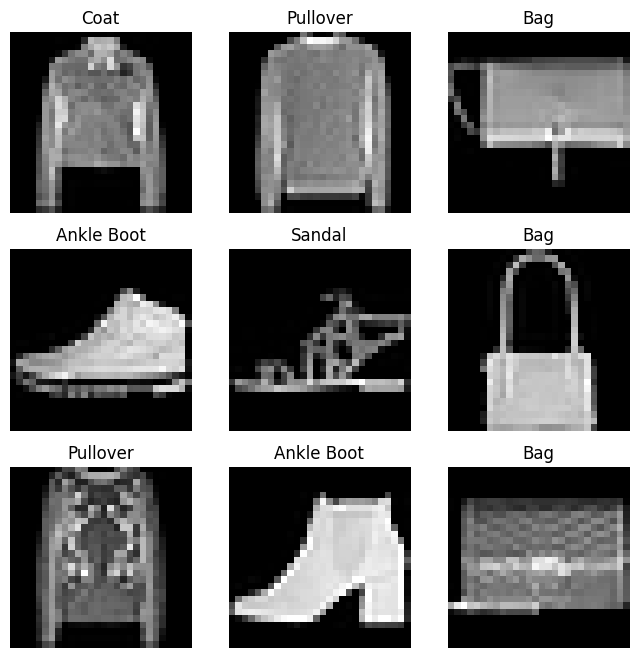

In [22]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
# Creates a new figure canvas (like a blank page).
# figsize=(8, 8) sets the figure size in inches.

cols, rows = 3, 3
# You want to show a 3×3 grid of images = 9 total images

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    # Picks a random index and extracts it as a plain Python int

    img, label = training_data[sample_idx]
    # img shape: [1, 28, 28]
    # label: integer from 0 to 9

    figure.add_subplot(rows, cols, i)
    # Adds a small subplot at position i in a 3×3 grid.

    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

**Preparing your data for training with DataLoaders**

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.
DataLoader is an iterable that abstracts this complexity for us in an easy API.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


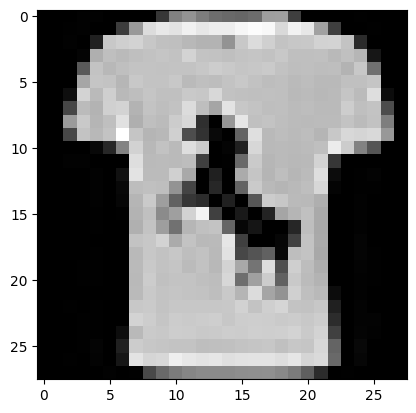

Label: 0


In [25]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Iterate through the DataLoader
# We have loaded that dataset into the DataLoader and can iterate through the dataset as needed. Each iteration below returns a batch of train_features and train_labels (containing batch_size=64 features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled.
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

#Transforms
Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic.

In [34]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

# It is loading the FashionMNIST training dataset, and:
#   Applying a transformation to images → convert to tensors
#   Applying a transformation to labels → convert to one-hot encoded vectors

# transform=ToTensor():
#   Converts the PIL image (from dataset) into a PyTorch tensor of shape [1, 28, 28] (grayscale image)
#   Scales pixel values from [0, 255] to [0.0, 1.0]

# target_transform=Lambda(...):
#   It is transforming integer labels (e.g., 5) into one-hot encoded vectors like: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

print(ds)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Target transform: Lambda()


#Build the Neural Network

In [7]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Get Device for Training
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
# We want to be able to train our model on an accelerator such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

# Define the Class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        # logits are the raw output scores for each of the 10 classes.
        return logits
# We define our neural network by subclassing nn.Module, and initialize the neural network layers in __init__. Every nn.Module subclass implements the operations on input data in the forward method.

# We create an instance of NeuralNetwork, and move it to the device, and print its structure.
model = NeuralNetwork().to(device)
print(model)


# nn.ReLU(): Non-linear activations are what create the complex mappings between the model’s inputs and outputs. They are applied after linear transformations to introduce nonlinearity, helping neural networks learn a wide variety of phenomena.

# nn.Linear(): The linear layer is a module that applies a linear transformation on the input using its stored weights and biases.

# nn.Sequential(): nn.Sequential is an ordered container of modules. The data is passed through all the modules in the same order as defined.

# nn.Flatten(): We initialize the nn.Flatten layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values ( the minibatch dimension (at dim=0) is maintained).

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [8]:
# To use the model, we pass it the input data. This executes the model’s forward, along with some background operations.
# Do not call model.forward() directly!
# Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output. We get the prediction probabilities by passing it through an instance of the nn.Softmax module.
X = torch.rand(1, 28, 28, device=device)
# Creates a random dummy image with shape [1, 28, 28]
# Batch size = 1
# Random values in the range [0, 1]

logits = model(X)
print(logits)
# Passes the dummy image through the model
# Output: raw scores (logits), shape [1, 10]

pred_probab = nn.Softmax(dim=1)(logits)
print(pred_probab)
# Converts logits into probabilities (between 0 and 1) using softmax
# dim=1 → applies softmax across class scores

y_pred = pred_probab.argmax(1)
# argmax(1) selects the class with the highest probability

print(f"Predicted class: {y_pred}")

# nn.Softmax(dim=1):
# The last linear layer of the neural network returns logits - raw values in [-infty, infty] - which are passed to the nn.Softmax module. The logits are scaled to values [0, 1] representing the model’s predicted probabilities for each class. dim parameter indicates the dimension along which the values must sum to 1.

tensor([[-0.0027,  0.0127, -0.0697, -0.0195, -0.0921, -0.0414,  0.0081,  0.0156,
          0.0345, -0.0387]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.1016, 0.1032, 0.0950, 0.0999, 0.0929, 0.0977, 0.1027, 0.1035, 0.1055,
         0.0980]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Predicted class: tensor([8], device='cuda:0')


**Model Parameters**

Many layers inside a neural network are parameterized, i.e. have associated weights and biases that are optimized during training. Subclassing nn.Module automatically tracks all fields defined inside your model object, and makes all parameters accessible using your model’s parameters() or named_parameters() methods.

In this example, we iterate over each parameter, and print its size and a preview of its values.

In [9]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0032,  0.0077,  0.0180,  ...,  0.0109,  0.0246,  0.0221],
        [ 0.0107,  0.0129, -0.0016,  ..., -0.0139,  0.0158,  0.0136]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0292,  0.0250], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0158, -0.0077, -0.0345,  ...,  0.0321, -0.0181,  0.0031],
        [ 0.0108, -0.0298, -0.0267,  ..., -0.0223,  0.0133, -0.0392]],
       device='cuda:0', grad_fn=<Sl

#Hyperparameters
Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates.

We define the following hyperparameters for training:

*   Number of Epochs - the number of times to iterate over the dataset

*   Batch Size - the number of data samples propagated through the network before the parameters are updated

*   Learning Rate - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.




#Optimization Loop
Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch.

Each epoch consists of two main parts:
*   The Train Loop - iterate over the training dataset and try to converge to optimal parameters.

*   The Validation/Test Loop - iterate over the test dataset to check if model performance is improving.

#Loss Function
When presented with some training data, our untrained network is likely not to give the correct answer. Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include nn.MSELoss (Mean Square Error) for regression tasks, and nn.NLLLoss (Negative Log Likelihood) for classification. nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss.

#Optimizer
Optimization is the process of adjusting model parameters to reduce model error in each training step. Optimization algorithms define how this process is performed (in this example we use Stochastic Gradient Descent). All optimization logic is encapsulated in the optimizer object. Here, we use the SGD optimizer; additionally, there are many different optimizers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:
*   Call optimizer.zero_grad() to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.

*   Backpropagate the prediction loss with a call to loss.backward(). PyTorch deposits the gradients of the loss w.r.t. each parameter.

*   Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.

In [16]:
# Full Implementation
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [18]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.295093  [   64/60000]
loss: 2.290995  [ 6464/60000]
loss: 2.270504  [12864/60000]
loss: 2.265166  [19264/60000]
loss: 2.252657  [25664/60000]
loss: 2.223448  [32064/60000]
loss: 2.224851  [38464/60000]
loss: 2.195570  [44864/60000]
loss: 2.189180  [51264/60000]
loss: 2.169596  [57664/60000]
Test Error: 
 Accuracy: 46.4%, Avg loss: 2.157479 

Epoch 2
-------------------------------
loss: 2.156834  [   64/60000]
loss: 2.160539  [ 6464/60000]
loss: 2.101710  [12864/60000]
loss: 2.122900  [19264/60000]
loss: 2.077777  [25664/60000]
loss: 2.014958  [32064/60000]
loss: 2.043661  [38464/60000]
loss: 1.965945  [44864/60000]
loss: 1.967569  [51264/60000]
loss: 1.916903  [57664/60000]
Test Error: 
 Accuracy: 59.0%, Avg loss: 1.903975 

Epoch 3
-------------------------------
loss: 1.922437  [   64/60000]
loss: 1.911190  [ 6464/60000]
loss: 1.788479  [12864/60000]
loss: 1.836766  [19264/60000]
loss: 1.736729  [25664/60000]
loss: 1.673482  [32064/600